# SOEN-6111 Project, Team#28

- Shreyans Sharma - 40196896
- Shubham Sharma - 40198289
- Shubhang Khattar - 40163063
- Bhavitha Yarlagadda - 40180618

**Introduction**

In this project we will create ML classification models using decision tree and K-nearest neighbors approach.
Models can ***predict the activity*** done by the subjects based on the motion sensor data

Data set used : MotionSense Dataset : Smartphone Sensor Data - HAR (https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset)

**About Dataset**

24 subjects (male and female) were asked to do 6 different activities in 15 trials in total. The motion sensor data was collected with an iPhone 6s in a 50Hz sample rate, which means 50 samples per second. The six activities done were the following, along with their abbreviation used in this dataset:

- dws: downstairs
- ups: upstairs
- sit: sitting
- std: standing
- wlk: walking
- jog: jogging

Of the 15 trials, the first 9 were "long" trials, while the trials 11-16 were the "short" version of their respective activity. Trial-ID 10 was left out. The trials in order were the following:

- 1: dws
- 2: dws
- 3: ups
- 4: ups
- 5: sit
- 6: std
- 7: wlk
- 8: wlk
- 9: jog
- 11: dws
- 12: ups
- 13: sit
- 14: std
- 15: wlk
- 16: jog

===========================================

Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from  sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn_evaluation import plot

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

path = 'archive/A_DeviceMotion_data/A_DeviceMotion_data/'

## Data Loading and Processing

### Data Loading

In [2]:
# Extracting list of directories

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

# Iterating through the extracted directories and appending each csv to dataframes for each subject in each of the trials.

for i in list_of_directories:
    list_of_csv = os.listdir(i)
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[-1].split('_')[0]
        k['trial'] = int(i.split('/')[-1].split('_')[1])
        
        # Deriving features from the given motion sensor data.
        
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)
        
# Creating final dataset dataframe from the list of all individual dataframes.
df = pd.concat(list_of_dfs).set_index('time')

# Dropping unnecessary columns and renaming the ones for rotation.
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

### Analyzing the dataset

In [3]:
print(f"""Total records in the dataset : {df.shape[0]}""")
df.sample(10)

Total records in the dataset : 1412865


,accel_x,accel_y,accel_z,accel_norm,gyro_x,gyro_y,gyro_z,subject,activity,trial
time,,,,,,,,,,
426,-0.151581,0.651383,0.421799,0.790690,-0.880415,-3.214401,-0.751245,11,jog,16
1870,-0.265777,0.846909,-0.295471,0.935519,3.301381,-0.175219,0.034957,6,ups,3
7752,-0.106323,0.881073,-0.083465,0.891381,-0.506813,0.284865,0.357355,18,wlk,7
6448,0.013596,1.066742,-0.121399,1.073714,-1.702162,-0.663908,-0.227165,12,wlk,7
1091,0.214157,1.187348,0.075333,1.208856,-0.330862,-0.053815,-0.534739,23,wlk,8
6294,-0.285767,0.702835,-0.052414,0.760518,-0.921936,1.520313,-1.016901,7,wlk,7
5392,-0.241120,0.983200,0.011902,1.012404,-0.009888,0.012410,0.017024,21,std,6
3180,-0.652603,1.663925,0.246155,1.804198,-1.596904,-0.552125,-0.708317,24,wlk,7
2029,-1.031937,0.210922,0.330505,1.103909,-0.179938,0.346892,0.427424,10,dws,1


### Class Distribution

Below is the distribution of various classes in the dataset


wlk    344288
sit    338778
std    306427
ups    157285
jog    134231
dws    131856
Name: activity, dtype: int64

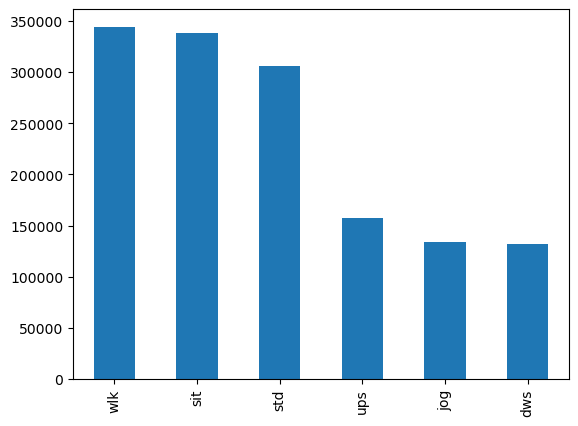

In [4]:
act = df["activity"].value_counts()
print("""Below is the distribution of various classes in the dataset""")
ax = act.plot(kind='bar')
act

# Model Training and Evaluation

## Preparing Data Set

### Train-Test Split

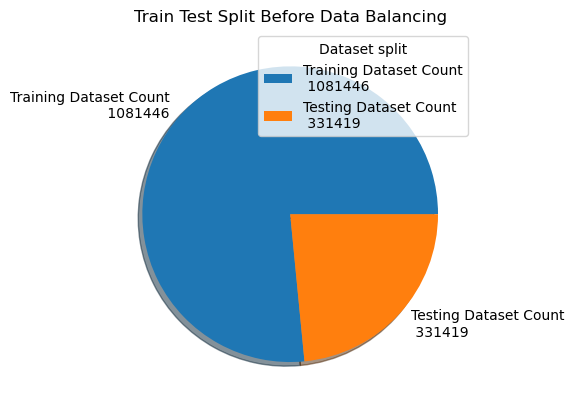

In [5]:
# Separating the dataset into a training set and a test set. 
# Making the cut between the long (1-9) as Training Dataset and the short trials (11-16) as Testing Dataset, 
# This ensures the evenly distribution of classes among training and testing data

train_long_df = df[(df.trial < 10)]
test_short_df = df[(df.trial > 10)]

# Extracting Features and Label for Training and Testing data.

X_train_long = train_long_df.iloc[:,:-3]
y_train_long = train_long_df.activity

X_test_short = test_short_df.iloc[:,:-3]
y_test_short = test_short_df.activity

plt.pie([len(y_train_long), len(y_test_short)], labels = [f"Training Dataset Count\n {len(train_long_df)}",f"Testing Dataset Count \n {len(test_short_df)}"], shadow = True)
plt.legend(title = "Dataset split")
plt.title('Train Test Split Before Data Balancing')
plt.show() 

### Data Balancing for Test Data

The datset is highly imbalanced we have very low samples for the class "upstairs", "jogging" and "downstairs"

We will balance the data using the SMOTE technique to oversample the data.

Before OverSampling, counts of label 'dws': 109354
Before OverSampling, counts of label 'ups': 129276
Before OverSampling, counts of label 'sit': 234657
Before OverSampling, counts of label 'std': 224816
Before OverSampling, counts of label 'wlk': 279016
Before OverSampling, counts of label 'jog': 104327

After OverSampling, the shape of X_train_long: (1674096, 7)
After OverSampling, the shape of y_train_long: (1674096, 7) 

Before OverSampling, counts of label 'dws': 279016
Before OverSampling, counts of label 'ups': 279016
Before OverSampling, counts of label 'sit': 279016
Before OverSampling, counts of label 'std': 279016
Before OverSampling, counts of label 'wlk': 279016
Before OverSampling, counts of label 'jog': 279016



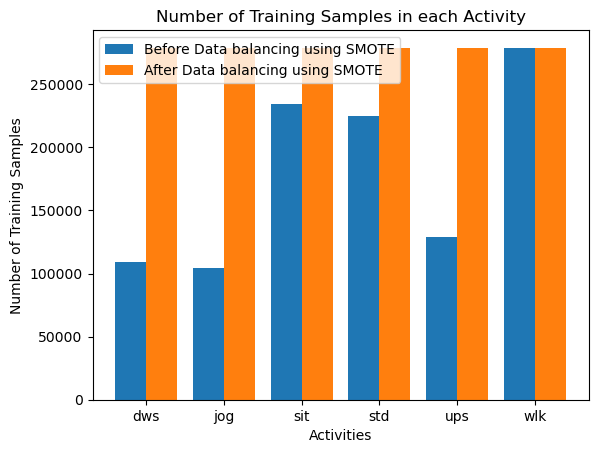

In [6]:
print("Before OverSampling, counts of label 'dws': {}".format(sum(y_train_long == "dws")))
print("Before OverSampling, counts of label 'ups': {}".format(sum(y_train_long == "ups")))
print("Before OverSampling, counts of label 'sit': {}".format(sum(y_train_long == "sit")))
print("Before OverSampling, counts of label 'std': {}".format(sum(y_train_long == "std")))
print("Before OverSampling, counts of label 'wlk': {}".format(sum(y_train_long == "wlk")))
print("Before OverSampling, counts of label 'jog': {}\n".format(sum(y_train_long == "jog")))

unique_elements, counts_elements_before = np.unique(y_train_long, return_counts=True)

sm = SMOTE(random_state = 2)
X_train_long, y_train_long = sm.fit_resample(X_train_long, y_train_long.ravel())

print('After OverSampling, the shape of X_train_long: {}'.format(X_train_long.shape))
print('After OverSampling, the shape of y_train_long: {} \n'.format(y_train_long.shape))

print("Before OverSampling, counts of label 'dws': {}".format(sum(y_train_long == "dws")))
print("Before OverSampling, counts of label 'ups': {}".format(sum(y_train_long == "ups")))
print("Before OverSampling, counts of label 'sit': {}".format(sum(y_train_long == "sit")))
print("Before OverSampling, counts of label 'std': {}".format(sum(y_train_long == "std")))
print("Before OverSampling, counts of label 'wlk': {}".format(sum(y_train_long == "wlk")))
print("Before OverSampling, counts of label 'jog': {}\n".format(sum(y_train_long == "jog")))

unique_elements, counts_elements_after = np.unique(y_train_long, return_counts=True)

X = unique_elements
before_smote = counts_elements_before
after_smote = counts_elements_after
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, before_smote, 0.4, label = 'Before Data balancing using SMOTE')
plt.bar(X_axis + 0.2, after_smote, 0.4, label = 'After Data balancing using SMOTE')
  
plt.xticks(X_axis, X)
plt.xlabel("Activities")
plt.ylabel("Number of Training Samples")
plt.title("Number of Training Samples in each Activity")
plt.legend()
plt.show()

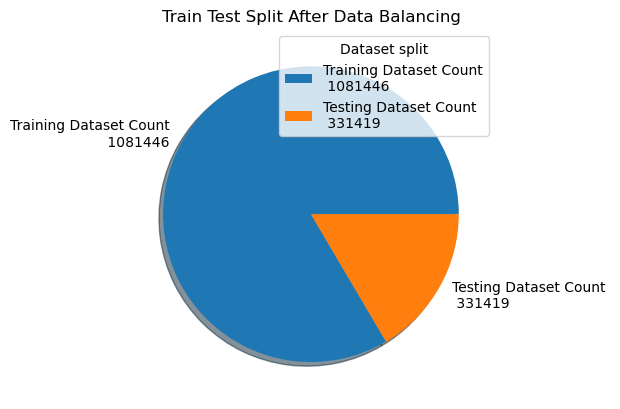

In [7]:
plt.pie([len(y_train_long), len(y_test_short)], labels = [f"Training Dataset Count\n {len(train_long_df)}",f"Testing Dataset Count \n {len(test_short_df)}"], shadow = True)
plt.legend(title = "Dataset split")
plt.title('Train Test Split After Data Balancing')
plt.show() 

## Decision Tree

***Model Creation and Training***

***Finding Maximum Optimal Depth Using Elbow Method***

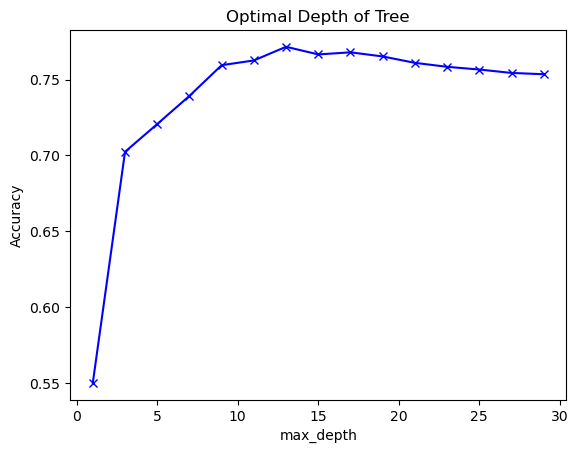

In [12]:
max_depth = range(1, 30, 2)

# List to store accuracy for each depth range
accuracy_dtc = []
for depth in max_depth:
    
    dtc = DecisionTreeClassifier(criterion="entropy",max_depth = depth, 
                             random_state = 0)
    dtc.fit(X_train_long, y_train_long)
    score = dtc.score(X_test_short, y_test_short)
    accuracy_dtc.append(score)

# Plotting max_depth vs Accuracy.
plt.plot(max_depth,accuracy_dtc,"bx-")
plt.xlabel("max_depth") 
plt.ylabel("Accuracy") 
plt.title("Optimal Depth of Tree")
plt.show()

***Opitmal Depth for the model is around 15, Will Tune other hyperparameters as well using Grid Search CV***

### Hyper Parameter Tuning Decision Tree Using Grid Search CV

Using Grid Search CV to find most optimal hyperparameters

In [14]:
param_grid = {
              'max_depth' : [14, 15, 16],
              'criterion' :['gini', 'entropy']
             }
dtc_grid = DecisionTreeClassifier(random_state=0)
grid_dtc_model = GridSearchCV(estimator=dtc_grid, param_grid=param_grid, cv=10, verbose=True)
grid_dtc_model.fit(X_train_long, y_train_long)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [14, 15, 16]},
             verbose=True)

In [15]:
grid_dtc_model.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=16, random_state=0)

### Decision Tree Evaluation

***Classification Report & Confusion Matrix***

In [17]:
# Prediciting labels for testing data
y_pred = grid_dtc_model.predict(X_test_short)

              precision    recall  f1-score   support

         dws       0.33      0.52      0.41     22502
         jog       0.52      0.64      0.57     29904
         sit       1.00      0.95      0.98    104121
         std       0.99      0.93      0.96     81611
         ups       0.41      0.51      0.46     28009
         wlk       0.71      0.52      0.60     65272

    accuracy                           0.77    331419
   macro avg       0.66      0.68      0.66    331419
weighted avg       0.80      0.77      0.78    331419



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

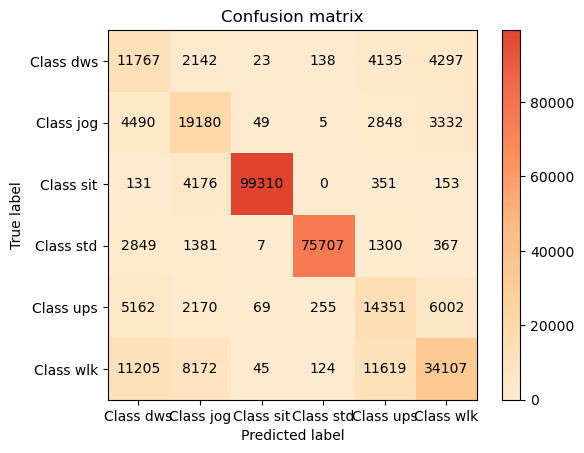

In [18]:
# Evaluating the performance of the model
print(classification_report(y_test_short, y_pred))
plot.confusion_matrix(y_test_short, y_pred)

### K-Fold Decision Tree
Traing and evaluate using K-Fold

In [20]:
X = pd.concat([X_train_long])
y = pd.DataFrame(y_train_long, columns = ['activity'])

k = 10
kf = KFold(n_splits=k, random_state=None)
model = DecisionTreeClassifier(criterion="entropy", max_depth = 16,random_state=0,)
k_fold_iter = 1
data = {}
f1_list = []
for train_index , test_index in kf.split(X):

    
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    f1 = f1_score(pred_values , y_test, average = 'weighted')
    f1_list.append(f1)
    print(f"""F1-Score for K-Fold {k_fold_iter} of {k} : {f1}""")
    data["Fold "+str(k_fold_iter)] = f1
    
    k_fold_iter += 1
    
    
avg_f1_score = sum(f1_list)/k

print("="*30)
print('Avg F1 Score : {}'.format(avg_f1_score))

F1-Score for K-Fold 1 of 10 : 0.12989735979886832
F1-Score for K-Fold 2 of 10 : 0.37300661059537255
F1-Score for K-Fold 3 of 10 : 0.5449052755817078
F1-Score for K-Fold 4 of 10 : 0.5996501696923556
F1-Score for K-Fold 5 of 10 : 0.9842313250206971
F1-Score for K-Fold 6 of 10 : 0.9543396482164872
F1-Score for K-Fold 7 of 10 : 0.6486326622220455
F1-Score for K-Fold 8 of 10 : 0.5711111008536339
F1-Score for K-Fold 9 of 10 : 0.8122919678399434
F1-Score for K-Fold 10 of 10 : 0.30696530991117316
Avg F1 Score : 0.5925031429732285


***Visualise K-Fold***

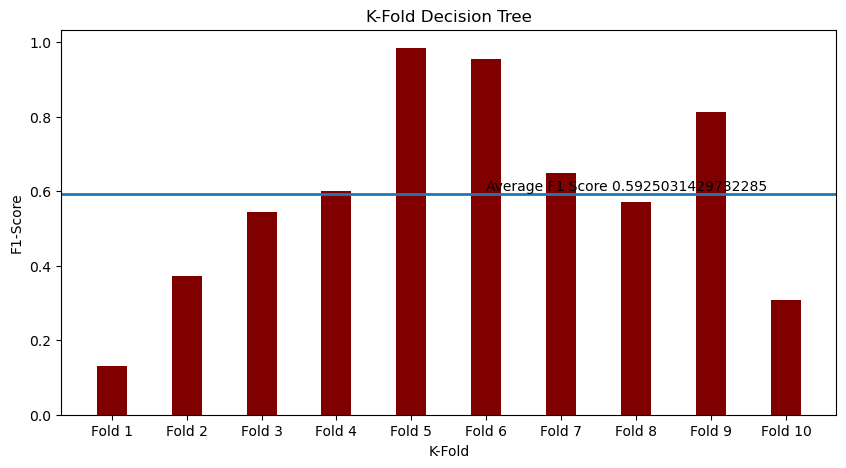

In [21]:
# ax.axvline(data1.mean(), color='blue', linewidth=2)

fold_list = list(data.keys())
f1_score_list = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(fold_list, f1_score_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("K-Fold")
plt.ylabel("F1-Score")
plt.title("K-Fold Decision Tree")
plt.axhline(y=avg_f1_score , linewidth=2)
h_line = "Average F1 Score " + str(avg_f1_score)
plt.text(5, avg_f1_score+0.01,h_line)
plt.show()

## K-Nearest Neighbors

***Model Creation and Training***

***Find best K-Value (Elbow Method)***

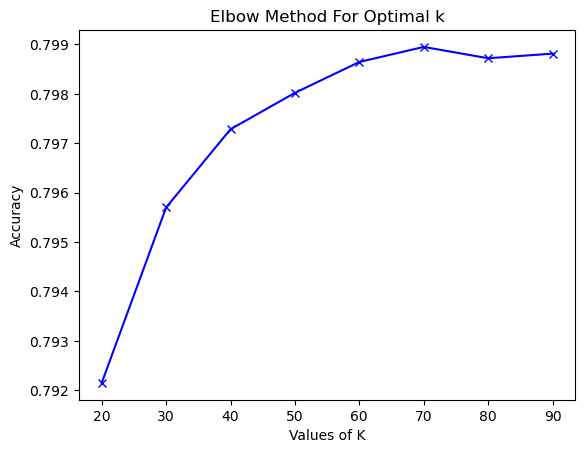

In [24]:
# List to store accuracy for each K range
    
accuracy_knn = []
K = range(20, 100, 10)
for num_clusters in K :
    knn = KNeighborsClassifier(n_neighbors=num_clusters)
    knn.fit(X_train_long,y_train_long)
    score = knn.score(X_test_short, y_test_short)
    accuracy_knn.append(score)

# Plotting K vs Accuracy.
plt.plot(K,accuracy_knn,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Accuracy") 
plt.title("Elbow Method For Optimal k")
plt.show()

***Opitmal K for KNN model is around 70***

### Hyperparameter Tuning KNN using Grid Search CV

In [25]:
# k_range = list(range(1, 31))
# weight_options = ['uniform', 'distance']
# param_grid = dict(n_neighbors=k_range, weights=weight_options)

param_grid_knn = {'n_neighbors': [65,70,75],
              'weights': ['uniform', 'distance'],
             }

knn = KNeighborsClassifier()
grid_knn_model = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=10, verbose=True)
grid_knn_model.fit(X_train_long, y_train_long)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [65, 70, 75],
                         'weights': ['uniform', 'distance']},
             verbose=True)

In [27]:
grid_knn_model.best_estimator_

KNeighborsClassifier(n_neighbors=65, weights='distance')

### KNN Evaluation

***Classification Report & Confusion Matrix***

In [28]:
# Prediciting labels for testing data
y_pred = grid_knn_model.predict(X_test_short)

              precision    recall  f1-score   support

         dws       0.33      0.56      0.41     22502
         jog       0.68      0.70      0.69     29904
         sit       1.00      0.95      0.97    104121
         std       0.99      0.94      0.96     81611
         ups       0.49      0.59      0.53     28009
         wlk       0.76      0.61      0.67     65272

    accuracy                           0.80    331419
   macro avg       0.71      0.72      0.71    331419
weighted avg       0.83      0.80      0.81    331419



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

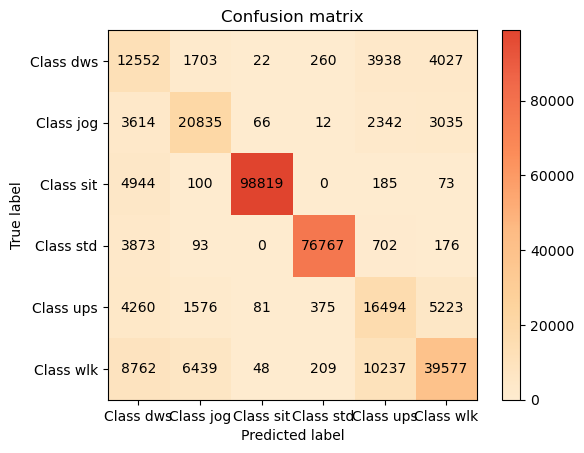

In [29]:
print(classification_report(y_test_short, y_pred))
plot.confusion_matrix(y_test_short, y_pred)

### K-Fold K-Nearest Neighbors

Traing and evaluate using K-Fold

In [31]:
X = pd.concat([X_train_long])
y = pd.DataFrame(y_train_long, columns = ['activity'])

k = 10
kf = KFold(n_splits=k, random_state=None)
model = KNeighborsClassifier(n_neighbors=65,weights='distance')
k_fold_iter = 1
data = {}
f1_list = []
for train_index , test_index in kf.split(X):

    
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    f1 = f1_score(pred_values , y_test, average = 'weighted')
    f1_list.append(f1)
    print(f"""F1-Score for K-Fold {k_fold_iter} of {k} : {f1}""")
    data["Fold "+str(k_fold_iter)] = f1
    
    k_fold_iter += 1
    
    
avg_f1_score = sum(f1_list)/k

print("="*30)
print('Avg F1 Score : {}'.format(avg_f1_score))

F1-Score for K-Fold 1 of 10 : 0.19783323044389342
F1-Score for K-Fold 2 of 10 : 0.4784136194812427
F1-Score for K-Fold 3 of 10 : 0.6813299370141669
F1-Score for K-Fold 4 of 10 : 0.7201475039294075
F1-Score for K-Fold 5 of 10 : 0.9906554730047606
F1-Score for K-Fold 6 of 10 : 0.9746731153388957
F1-Score for K-Fold 7 of 10 : 0.7385549469656314
F1-Score for K-Fold 8 of 10 : 0.689876224809246
F1-Score for K-Fold 9 of 10 : 0.8716492151935885
F1-Score for K-Fold 10 of 10 : 0.48911557897208147
Avg F1 Score : 0.6832248845152915


***Visualise K-Fold***

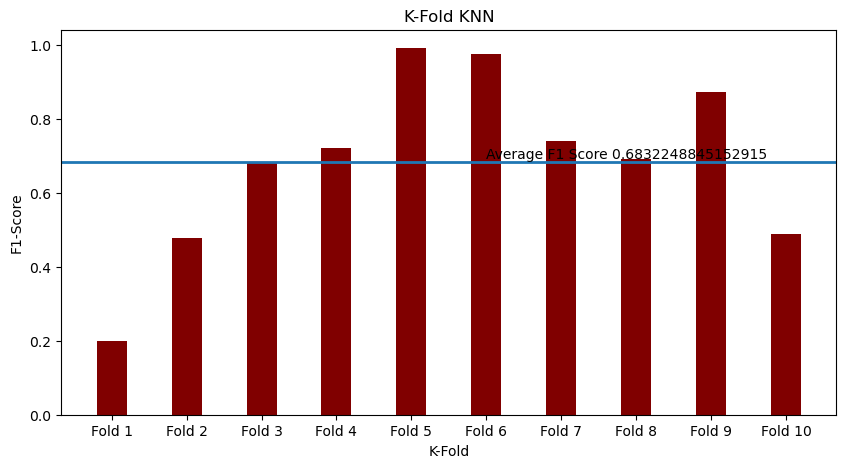

In [32]:
# ax.axvline(data1.mean(), color='blue', linewidth=2)

fold_list = list(data.keys())
f1_score_list = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(fold_list, f1_score_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("K-Fold")
plt.ylabel("F1-Score")
plt.title("K-Fold KNN")
plt.axhline(y=avg_f1_score , linewidth=2)
h_line = "Average F1 Score " + str(avg_f1_score)
plt.text(5, avg_f1_score+0.01,h_line)
plt.show()